# Data Analysis and Machine Learning Applications for Physicists

*Material for a* [*University of Illinois*](http://illinois.edu) *course offered by the* [*Physics Department*](https://physics.illinois.edu). *This content is maintained on* [*GitHub*](https://github.com/illinois-mla) *and is distributed under a* [*BSD3 license*](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
from mls import plot_rosenbrock, plot_posterior

## Frameworks

In this notebook, we introduce on some useful frameworks for practical calculations, rather than describe any new techniques.  We consider two types of frameworks:
 - Frameworks to build and efficiently run a computational graph.
 - Frameworks for [probabilistic programming](https://en.wikipedia.org/wiki/Probabilistic_programming_language).
 
Note that a probabilistic programming framework often builds on a lower-level computational graph framework.

### Computation Graphs: Tensorflow

Machine learning architectures around computations graphs very powerful
* define a computation graph
* provide data and a training strategy (e.g., batching)
* toolkit does the rest

TensorFlow is a graph based processing framework that is really well suited for building Machine Learning models. TensorFlow uses a dataflow graph to represent your computation in terms of the dependencies between individual operations. This leads to a low-level programming model in which you first define the dataflow graph, then create a TensorFlow session to run parts of the graph across a set of local and remote devices.

https://www.tensorflow.org/programmers_guide/low_level_intro#graph

In [3]:
import tensorflow as tf

In [4]:
print(tf.__version__)

1.7.0


#### Example: calculation with constants

Here is a simple calculation in python involving constants:

In [5]:
a = 1.0
b = 2.0
c = a + b
print(' a = {}\n b = {}\n c = {}'.format(a, b, c))

 a = 1.0
 b = 2.0
 c = 3.0


The tensorflow equivalent is more involved since it requires two stages. First, we build a graph, which captures the structure of the calculation but contains no values:

In [6]:
g1 = tf.Graph()
with g1.as_default():
    a = tf.constant(1.0, name='a')
    b = tf.constant(2.0, name='b')
    c = tf.add(a, b, name='c') # a + b also valid but is un-named.
print(' a = {}\n b = {}\n c = {}'.format(a, b, c))

 a = Tensor("a:0", shape=(), dtype=float32)
 b = Tensor("b:0", shape=(), dtype=float32)
 c = Tensor("c:0", shape=(), dtype=float32)


The `tensorboard` program allows graphs (and summary results) to be visualized in the browser:

In [7]:
tf.summary.FileWriter('tfs/intro1', graph=g1);

```
% tensorboard --logdir tfs/intro1 --host localhost --port=8080
TensorBoard 1.5.1 at http://localhost:6006 (Press CTRL+C to quit)
```

![sum graph](img/Frameworks/sum_graph.png)

The second stage is to run the graph in a session:

In [8]:
with tf.Session(graph=g1) as s1:
    c_out = s1.run(c)
print(' c = {}'.format(c_out))

 c = 3.0


#### Example: calculation with variables

In [9]:
def rosenbrock(x):
    x0, x1 = x
    a, b = 1., 100.
    return (a - x0) ** 2 + b * (x1 - x0 ** 2) ** 2

In [10]:
print(rosenbrock([1., 1.]))
print(rosenbrock([0.5, -0.5]))

0.0
56.5


In [11]:
g2 = tf.Graph()
with g2.as_default():
    x = tf.placeholder(tf.float32, shape=(2,), name='x')
    x0 = tf.slice(x, [0], [1], name='x0')
    x1 = tf.slice(x, [1], [1], name='x1')
    a = tf.constant(1., name='a')
    b = tf.constant(100., name='b')
    with tf.name_scope('rosenbrock'):
        rosenbrock = (a - x0) ** 2 + b * (x1 - x0 ** 2) ** 2

In [12]:
tf.summary.FileWriter('tfs/intro2', graph=g2);

The new tensorboard graph is:
![rosenbrock graph](img/Frameworks/rosenbrock_graph.png)
Double clicking on the "rosenbrock" node reveals its internal structure, composed of primitive building blocks:
![rosenbrock graph](img/Frameworks/rosenbrock_graph2.png)

In [13]:
with tf.Session(graph=g2) as s2:
    print(s2.run(rosenbrock, feed_dict={x: [1., 1.]}))
    print(s2.run(rosenbrock, feed_dict={x: [0.5, -0.5]}))

[0.]
[56.5]


Add the line:
```
    rosenbrock_grad = tf.gradients(rosenbrock, [x])
```
to the example above to extend the graph to calculate the partial derivatives of the Rosenbrock function with respect to the components of `x`:

In [14]:
g3 = tf.Graph()
with g3.as_default():
    x = tf.placeholder(tf.float32, shape=(2,), name='x')
    x0 = tf.slice(x, [0], [1], name='x0')
    x1 = tf.slice(x, [1], [1], name='x1')
    a = tf.constant(1., name='a')
    b = tf.constant(100., name='b')
    with tf.name_scope('rosenbrock'):
        rosenbrock = (a - x0) ** 2 + b * (x1 - x0 ** 2) ** 2
    rosenbrock_grad = tf.gradients(rosenbrock, [x])

In [15]:
tf.summary.FileWriter('tfs/intro3', graph=g3);

In [16]:
with tf.Session(graph=g3) as s3:
    print(s3.run(rosenbrock_grad, feed_dict={x: [1., 1.]}))
    print(s3.run(rosenbrock_grad, feed_dict={x: [0.5, -0.5]}))

[array([0., 0.], dtype=float32)]
[array([ 149., -150.], dtype=float32)]


#### Example: optimization

Add the lines:
```
    optimizer = tf.train.AdamOptimizer(learning_rate=0.05, name='optimizer')
    step = optimizer.minimize(rosenbrock, name='step')
```
to extend the graph to perform optimization, i.e., to iteratively update `x` to move towards a (local) minimum. We also need to change `x` from a `placeholder` to a `Variable` since it is now being updated internally:

In [17]:
g4 = tf.Graph()
with g4.as_default():
    x = tf.Variable([-1., 0.], name='x')
    x0 = tf.slice(x, [0], [1], name='x0')
    x1 = tf.slice(x, [1], [1], name='x1')
    a = tf.constant(1., name='a')
    b = tf.constant(100., name='b')
    with tf.name_scope('rosenbrock'):
        rosenbrock = (a - x0) ** 2 + b * (x1 - x0 ** 2) ** 2
    optimizer = tf.train.AdamOptimizer(learning_rate=0.05, name='optimizer')
    step = optimizer.minimize(rosenbrock, name='step')
    initialize = tf.global_variables_initializer()

The graph knows what variables it can be optimized (trained) over:

In [18]:
g4.get_collection('trainable_variables')

[<tf.Variable 'x:0' shape=(2,) dtype=float32_ref>]

Run the optimizer in a session and save its path. You can also [save summary data](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard#serializing_the_data) to the log file for later inspection in tensorboard.

In [19]:
with tf.Session(graph=g4) as s4:
    s4.run(initialize)
    path = [s4.run(x)]
    for i in range(2000):
        s4.run(step)
        path.append(s4.run(x))

Note that the [Adam optimizer](https://arxiv.org/abs/1412.6980) is relatively new (2014) and not yet implemented (as of 2018) in `scipy.optimize`, but is popular for deep-learning optimization. In this example, it quickly finds the curved valley, but requires many steps to zero in on its shallow minimum:

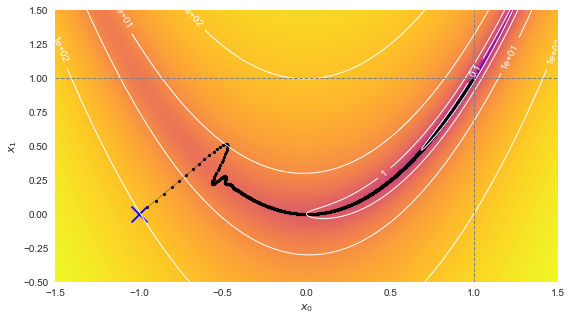

In [20]:
plot_rosenbrock(path=path);